In [25]:
import torchaudio
import torch
import pandas as pd
from speechbrain.pretrained import EncoderClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [2]:
classes = ['england', 'us', 'canada', 'australia', 'indian', 'scotland', 'ireland', 'african', 'malaysia', 'newzealand', 'southatlandtic', 'bermuda', 'philippines', 'hongkong', 'wales', 'singapore']

In [3]:
test_path = '/home/dan/slt/accent_data'
source_path = '/home/dan/slt/embedding_model.ckpt'
hparams_path = '/home/dan/slt/hyperparams.yaml'

In [4]:
classifier = EncoderClassifier.from_hparams(source=source_path, hparams_file=hparams_path)

data/rir_folder/rirs_noises.zip exists. Skipping download


In [5]:
test_items = pd.read_csv(f'{test_path}/test.csv')

In [35]:
y_true = []
y_pred = []
embeddings = []

In [8]:
outputs = {}
def get_activation(name):
    def hook(model, input, output):
        outputs['embedding_model'] = output.detach()
    return hook
classifier.mods.embedding_model.register_forward_hook(get_activation('embedding_model'))

In [36]:
for index, row in test_items.iterrows():
    filepath = f"{test_path}/test/{row['utt_id']}.wav"
    y_true.append(row['accent'])
    out_prob, score, index, text_lab = classifier.classify_file(filepath)
    y_pred.append(text_lab)
    embeddings.append(outputs['embedding_model'].squeeze().cpu().numpy())

## Classification stats

In [50]:
cm = confusion_matrix(y_true, y_pred, labels=classes)

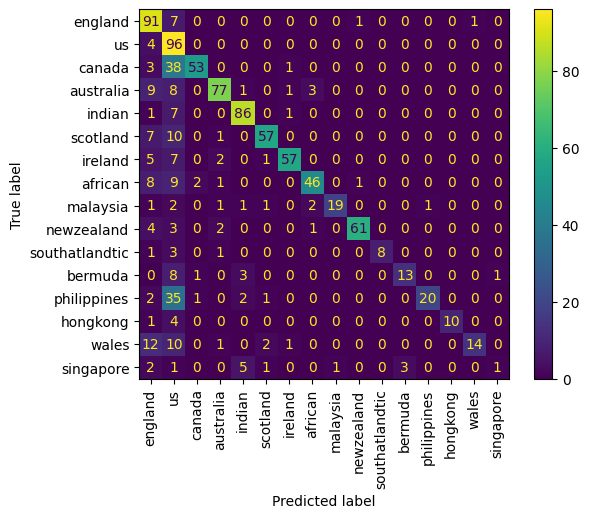

In [51]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
disp.ax_.tick_params(axis='x', labelrotation = 90)

In [52]:
print(classification_report(y_true, y_pred))

                precision    recall  f1-score   support

       african       0.88      0.69      0.77        67
     australia       0.90      0.78      0.83        99
       bermuda       0.81      0.50      0.62        26
        canada       0.93      0.56      0.70        95
       england       0.60      0.91      0.73       100
      hongkong       1.00      0.67      0.80        15
        indian       0.88      0.91      0.89        95
       ireland       0.93      0.79      0.86        72
      malaysia       0.95      0.68      0.79        28
    newzealand       0.97      0.86      0.91        71
   philippines       0.95      0.33      0.49        61
      scotland       0.90      0.76      0.83        75
     singapore       0.50      0.07      0.12        14
southatlandtic       1.00      0.62      0.76        13
            us       0.39      0.96      0.55       100
         wales       0.93      0.35      0.51        40

      accuracy                           0.73 

## Exploring embeddings

In [94]:
n_components = 2
tsne = TSNE(n_components=n_components)
tsne_result = tsne.fit_transform(np.array(embeddings))

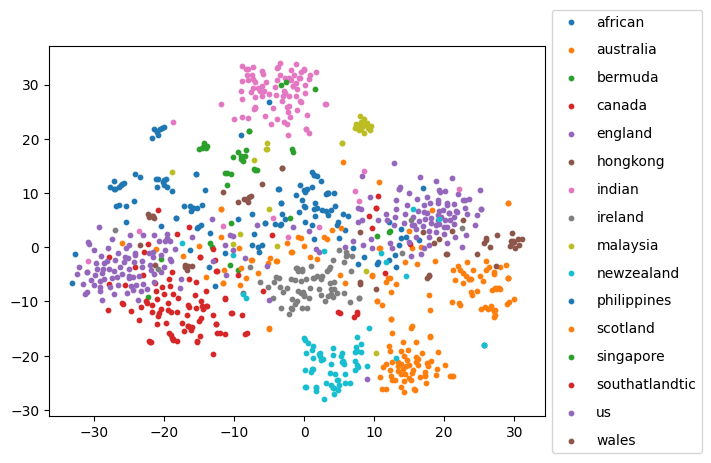

In [95]:
cmap = plt.get_cmap('tab20', len(classes))
fig, ax = plt.subplots()

groups = pd.DataFrame(tsne_result, columns=['x', 'y']).assign(accent=test_items['accent']).groupby('accent')
for name, points in groups:
    ax.scatter(points.x, points.y, label=name, s=10)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), labelspacing=1);